## Refined application of the Keras-WTTF to the NASA Turbofan dataset and comparison of two proposed activation functions

In [1]:
import numpy as np
import keras

from keras import backend as k
from keras import callbacks

from sklearn.preprocessing import normalize
import pandas as pd
%matplotlib inline


import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Masking

from keras.layers import LSTM,GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam


np.random.seed(1337)
pd.set_option("display.max_rows",1000)

Using TensorFlow backend.


#### The activation for the output layers as proposed initially in the Thesis, and Log-Likelyhood

In [19]:
def _keras_unstack_hack(ab):
    """Implements tf.unstack(y_true_keras, num=2, axis=-1).
       Keras-hack adopted to be compatible with theano backend.
    """
    ndim = len(K.int_shape(ab))
    if ndim == 0:
        print('can not unstack with ndim=0')
    else:
        a = ab[..., 0]
        b = ab[..., 1]
    return a, b


def weibull_loss_discrete(y_true, y_pred, name=None):
    """calculates a keras loss op designed for the sequential api.
    
        Discrete log-likelihood for Weibull hazard function on censored survival data.
        For math, see 
        https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf (Page 35)
        
        Args:
            y_true: tensor with last dimension having length 2
                with y_true[:,...,0] = time to event, 
                     y_true[:,...,1] = indicator of not censored
                
            y_pred: tensor with last dimension having length 2 
                with y_pred[:,...,0] = alpha, 
                     y_pred[:,...,1] = beta

        Returns:
            A positive `Tensor` of same shape as input
            
    """    
    y, u = y_true[..., 0], y_true[..., 1]
    a, b = y_pred[..., 0], y_pred[..., 1]

    hazard0 = K.pow((y + 1e-35) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)
    
    loglikelihoods = u * K.log((1.0 + 1e-35) - K.exp(hazard0 - hazard1)) - hazard0
    loss = -1 * K.mean(loglikelihoods)
    return loss


def output_lambda(x, init_alpha=1.0, max_beta_value=5.0, max_alpha_value=None):
    """Elementwise (Lambda) computation of alpha and regularized beta.

        Alpha: 
        (activation) 
        Exponential units seems to give faster training than 
        the original papers softplus units. Makes sense due to logarithmic
        effect of change in alpha. 
        (initialization) 
        To get faster training and fewer exploding gradients,
        initialize alpha to be around its scale when beta is around 1.0,
        approx the expected value/mean of training tte. 
        Because we're lazy we want the correct scale of output built
        into the model so initialize implicitly; 
        multiply assumed exp(0)=1 by scale factor `init_alpha`.

        Beta: 
        (activation) 
        We want slow changes when beta-> 0 so Softplus made sense in the original 
        paper but we get similar effect with sigmoid. It also has nice features.
        (regularization) Use max_beta_value to implicitly regularize the model
        (initialization) Fixed to begin moving slowly around 1.0

        Assumes tensorflow backend.

        Args:
            x: tensor with last dimension having length 2
                with x[...,0] = alpha, x[...,1] = beta

        Usage:
            model.add(Dense(2))
            model.add(Lambda(output_lambda, arguments={"init_alpha":100., "max_beta_value":2.0}))
        Returns:
            A positive `Tensor` of same shape as input
    """
    a, b = _keras_unstack_hack(x)

    # Implicitly initialize alpha:
    if max_alpha_value is None:
        a = init_alpha * K.exp(a)
    else:
        a = init_alpha * K.clip(x=a, min_value=K.epsilon(),
                                max_value=max_alpha_value)

    m = max_beta_value
    if m > 1.05:  # some value >>1.0
        # shift to start around 1.0
        # assuming input is around 0.0
        _shift = np.log(m - 1.0)

        b = K.sigmoid(b - _shift)
    else:
        b = K.sigmoid(b)

    # Clipped sigmoid : has zero gradient at 0,1
    # Reduces the small tendency of instability after long training
    # by zeroing gradient.
    b = m * K.clip(x=b, min_value=K.epsilon(), max_value=1. - K.epsilon())

    x = K.stack([a, b], axis=-1)

    return x

def activate(ab):
    """Activation function retaining softplus activation on beta as originally used in the paper."""
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])

    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))

    return k.concatenate((a, b), axis=1)

##### Preparing the input data to be in a suitable DataFrame

In [3]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols
np.set_printoptions(suppress=True, threshold=10000)

train_orig = pd.read_csv('../../keras-wtte-rnn/train.csv', header=None, names=column_names)
test_x_orig = pd.read_csv('../../keras-wtte-rnn/test_x.csv', header=None, names=column_names)
test_y_orig = pd.read_csv('../../keras-wtte-rnn/test_y.csv', header=None, names=['T'])

# This will later be used in the feature generation. Background is that for the test set, we want to map the remaining TTF
# according to the info given by the "test_y.csv", while retaining the TTF per cycle similar to how it would be in the
# training dataset.
test_y_orig.index += 1

In [4]:
test_x_orig['TTF'] = test_x_orig.groupby("unit_number")["time"].rank(method="min", ascending=False)
mapper = test_y_orig["T"] - 1
mapped_value = test_x_orig["unit_number"].map(mapper)
test_x_orig['TTF'] = test_x_orig['TTF'] + mapped_value
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True, inplace=True)


In [5]:
train_orig['TTF'] = train_orig.groupby("unit_number")["time"].rank(method="min", ascending=False)
train_orig.set_index(['unit_number', 'time'], verify_integrity=True, inplace=True)

In [6]:
train_orig.head()

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_13  \
unit_number time                        ...                          
1           1                   554.36  ...                2388.02   
            2                   553.75  ...                2388.07   
            3                   554.26  ...                2388.03   
            4                   554.45  ...                2388.08   
            5                   554.00  ...                2388.04   

                  sensor_measurement_14  sensor_measurement_15  \
unit_number time                                                 
1           1                   8138.62                 8.4195   
            2                   8131.49                 8.4318   
            3                   8133.23                 8.4178   
            4                   8133.83                 8.3682   
            5                   8133.80                 8.4294   

                  sensor_measurement_16  sensor_measurement_17  \
unit_number time                                                 
1           1                      0.03                    392   
            2                      0.03                    392   
            3                      0.03                    390   
            4                      0.03                    392   
            5                      0.03                    393   

                  sensor_measurement_18  sensor_measurement_19  \
unit_number time                                                 
1           1                      2388                  100.0   
            2                      2388                  100.0   
            3                      2388                  100.0   
            4                      2388                  100.0   
            5                      2388                  100.0   

                  sensor_measurement_20  sensor_measurement_21    TTF  
unit_number time                                                       
1           1                     39.06                23.4190  192.0  
            2                     39.00                23.4236  191.0  
            3                     38.95                23.3442  190.

In [7]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Combine the X values to normalize them, 
all_data_orig = pd.concat([train_orig, test_x_orig])
# print(all_data_orig.columns, all_data_orig.index)
all_data = all_data_orig.copy()
# all_data[feature_cols] = normalize(all_data[feature_cols].values)

def preprocess(df, feature_cols, scaler=None):
    try:
        df.loc[:, feature_cols] = scaler.transform(df[feature_cols])
    except AttributeError:
        df.loc[:, feature_cols] = StandardScaler().fit_transform(df[feature_cols])
    
    selector = VarianceThreshold() #Defaults to 0.0, e.g. only remove features with the same value in all samples
    #Fit the Model and obtain remaining columns
    selector.fit(df[feature_cols])
    features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
    features = [column for column in df[feature_cols].columns[features]] #Array of all nonremoved features' names

    #Format and Return
    selector = pd.DataFrame(selector.transform(df[feature_cols]))
    selector.columns = features
    selector.index = df.index
    return features, selector
new_features, all_data = preprocess(all_data, feature_cols)

D:\anaconda\envs\nlp\lib\site-packages\ipykernel\zmqshell.py:533: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [8]:
all_data_orig.columns

Index(['op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_measurement_1',
       'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4',
       'sensor_measurement_5', 'sensor_measurement_6', 'sensor_measurement_7',
       'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_10',
       'sensor_measurement_11', 'sensor_measurement_12',
       'sensor_measurement_13', 'sensor_measurement_14',
       'sensor_measurement_15', 'sensor_measurement_16',
       'sensor_measurement_17', 'sensor_measurement_18',
       'sensor_measurement_19', 'sensor_measurement_20',
       'sensor_measurement_21', 'TTF'],
      dtype='object')

In [9]:
remaining_cols = [col for col in train_orig.columns.tolist() if col in new_features] + ["TTF"]
all_data_orig.loc[:, new_features] = all_data
all_data_orig = all_data_orig[remaining_cols]

D:\anaconda\envs\nlp\lib\site-packages\ipykernel\ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)


In [10]:
all_data_orig.head()

op_setting_1  op_setting_2  sensor_measurement_2  \
unit_number time                                                     
1           1        -0.314711     -1.373690             -1.644975   
            2         0.870755     -1.032895             -0.949920   
            3        -1.956125      1.011877             -0.528674   
            4         0.323617     -0.010509             -0.528674   
            5        -0.861849     -0.692099             -0.486549   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                 0.020217             -0.794964   
            2                 0.383216             -0.493750   
            3                -0.272579             -0.368046   
            4                -1.162954             -0.644357   
            5                -1.152680             -0.128498   

                  sensor_measurement_6  sensor_measurement_7  \
unit_number time                                               
1           1                 0.155673              1.008357   
            2                 0.155673              0.276905   
            3                 0.155673              0.888447   
            4                 0.155673              1.116276   
            5                 0.155673              0.576681   

                  sensor_measurement_8  sensor_measurement_9  \
unit_number time                                               
1           1                -0.396802             -0.864091   
            2                -0.694283             -0.975799   
            3                -0.099321             -0.508416   
            4                 0.346901             -0.690733   
            5                -0.396802             -0.391966   

                  sensor_measurement_11  sensor_measurement_12  \
unit_number time                                                 
1           1                 -0.090766               0.168348   
            2                 -0.010603               1.062424   
            3                 -0.892393               1.264312   
            4                 -1.453533               1.898818   
            5                 -0.852312               0.932638   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
1           1                 -0.981906              -0.199424   
            2                 -0.242468              -0.634651   
            3                 -0.834018              -0.528438   
            4                 -0.094581              -0.491813   
            5                 -0.686131              -0.493645   

                  sensor_measurement_15  sensor_measurement_17  \
unit_number time                                                 
1           1                 -0.461431              -0.655669   
            2                 -0.113571              -0.655669   
            3                 -0.509509              -2.018065   
            4                 -1.912263              -0.655669   
            5                 -0.181446               0.025530   

                  sensor_measurement_20  sensor_measurement_21    TTF  
unit_number time                                                       
1           1                  1.254019               1.091572  192.0  
            2                  0.902637               1.136638  191.0  
            3                  0.609819               0.358754  190.0  
            4                  0.199874               0.649726  189.0  
            5                  0.317001               0.948535  188.0

In [11]:
# Make engine numbers and days zero-indexed, then split them back into train and test data
all_data_orig.index.set_levels((all_data_orig.index.levels[0]-1, all_data_orig.index.levels[1]-1), (0,1), inplace=True)
train_ = all_data_orig.iloc[0:train_orig.shape[0], :]
test_ = all_data_orig.iloc[train_orig.shape[0]:, :]

#train.loc[:, 0:2] -= 1
#test.loc[:, 0:2] -= 1


In [25]:
train_.head()

op_setting_1  op_setting_2  sensor_measurement_2  \
unit_number time                                                     
0           0        -0.314711     -1.373690             -1.644975   
            1         0.870755     -1.032895             -0.949920   
            2        -1.956125      1.011877             -0.528674   
            3         0.323617     -0.010509             -0.528674   
            4        -0.861849     -0.692099             -0.486549   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
0           0                 0.020217             -0.794964   
            1                 0.383216             -0.493750   
            2                -0.272579             -0.368046   
            3                -1.162954             -0.644357   
            4                -1.152680             -0.128498   

                  sensor_measurement_6  sensor_measurement_7  \
unit_number time                                               
0           0                 0.155673              1.008357   
            1                 0.155673              0.276905   
            2                 0.155673              0.888447   
            3                 0.155673              1.116276   
            4                 0.155673              0.576681   

                  sensor_measurement_8  sensor_measurement_9  \
unit_number time                                               
0           0                -0.396802             -0.864091   
            1                -0.694283             -0.975799   
            2                -0.099321             -0.508416   
            3                 0.346901             -0.690733   
            4                -0.396802             -0.391966   

                  sensor_measurement_11  sensor_measurement_12  \
unit_number time                                                 
0           0                 -0.090766               0.168348   
            1                 -0.010603               1.062424   
            2                 -0.892393               1.264312   
            3                 -1.453533               1.898818   
            4                 -0.852312               0.932638   

                  sensor_measurement_13  sensor_measurement_14  \
unit_number time                                                 
0           0                 -0.981906              -0.199424   
            1                 -0.242468              -0.634651   
            2                 -0.834018              -0.528438   
            3                 -0.094581              -0.491813   
            4                 -0.686131              -0.493645   

                  sensor_measurement_15  sensor_measurement_17  \
unit_number time                                                 
0           0                 -0.461431              -0.655669   
            1                 -0.113571              -0.655669   
            2                 -0.509509              -2.018065   
            3                 -1.912263              -0.655669   
            4                 -0.181446               0.025530   

                  sensor_measurement_20  sensor_measurement_21    TTF  
unit_number time                                                       
0           0                  1.254019               1.091572  192.0  
            1                  0.902637               1.136638  191.0  
            2                  0.609819               0.358754  190.0  
            3                  0.199874               0.649726  189.0  
            4                  0.317001               0.948535  188.0

In [27]:
test_

op_setting_1  op_setting_2  sensor_measurement_2  \
unit_number time                                                     
0           0         1.053135      1.011877              0.882500   
            1        -1.226608     -1.032895             -1.876661   
            2         0.141238      0.330287             -0.296989   
            3         1.919437     -0.010509             -0.339113   
            4         0.642781     -0.010509             -0.191677   
            5         0.551591      1.011877             -1.034169   
            6         0.004453      0.671082             -1.034169   
            7         0.278022     -0.010509             -0.128490   
            8        -1.636962     -0.010509             -1.518602   
            9        -1.135418     -0.351304             -1.118418   
            10        0.323617     -1.373690             -1.181605   
            11        1.189919      1.011877             -0.128490   
            12       -2.548859      1.011877             -1.392228   
            13        0.779566     -1.373690             -0.781421   
            14       -0.132331     -1.032895             -0.212739   
            15       -0.816254      1.011877             -0.591861   
            16        0.642781      0.671082             -0.865671   
            17        1.600273      0.330287             -0.023179   
            18        1.326704      0.330287             -0.360175   
            19        0.505996     -0.351304              0.018946   
            20        1.737057     -0.692099              0.208507   
            21        0.551591      0.330287             -0.318051   
            22        0.414807     -0.010509             -1.013107   
            23       -0.269116     -0.351304             -0.591861   
            24        1.281109     -1.032895             -0.739297   
            25        2.147411     -1.714485             -0.254864   
            26       -0.314711      0.330287             -1.097356   
            27        1.007540      1.693468             -1.413290   
            28        0.642781      0.330287             -1.371166   
            29       -1.135418      1.352672              0.398067   
            30       -0.269116      1.352672             -0.044241   
1           0        -0.405901      1.352672              0.124257   
            1        -0.497090      0.671082             -0.191677   
            2         0.095643      1.011877             -0.044241   
            3         1.144324      0.330287             -0.612923   
            4         0.186832     -1.373690              0.355943   
            5        -0.360306     -1.032895             -0.212739   
            6         0.870755     -0.010509              0.061070   
            7         0.688376      1.011877              0.018946   
            8        -0.998634      1.011877             -0.676110   
            9         0.961945      1.352672             -0.149552   
            10       -0.451495     -0.010509             -0.065303   
            11        1.007540     -0.351304              0.208507   
            12        1.554678      0.330287             -0.528674   
            13       -0.588280     -0.010509             -0.296989   
            14       -0.405901     -0.010509             -0.570798   
            15        0.825160     -0.692099             -0.128490   
            16       -0.542685      1.693468             -1.455415   
            17        0.232427      0.330287             -0.318051   
            18        0.232427     -0.010509             -0.486549   
            19        1.782652      1.352672              0.250631   
            20       -1.728151     -1.032895             -0.591861   
            21        0.232427      1.011877             -0.339113   
            22       -0.132331      1.011877              0.187444   
            23        0.460402     -1.373690              1.198434   
            24        0.6427

In [12]:
from tqdm import tqdm

def create_rnn_input(df, seq_len = 20):
    def sequence_generation(df):
        for ID in tqdm(range(np.max(df.index.get_level_values("unit_number").values))):
            feat_seq = (df.loc[ID,:].loc[max(0, cycle-(seq_len-1)):cycle, remaining_cols] \
                        for cycle in df.query('unit_number == {:d}'.format(ID)).index.get_level_values("time"))
            yield from feat_seq
    gen_seq = sequence_generation(df)
    gen_pad = (np.pad(arr, ((seq_len-arr.shape[0],0),(0,0)), "constant", constant_values=-99) for arr in gen_seq)
    return gen_pad

In [13]:
max_time = 25
train_sequences = create_rnn_input(train_, max_time)
#train_seq = np.concatenate(train_sequences)
train_tensor = np.stack(train_sequences)


D:\anaconda\envs\nlp\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  after removing the cwd from sys.path.
100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:38<00:00,  2.41it/s]


In [14]:
#np.random.shuffle(train_tensor)
train_x, train_y = np.split(train_tensor, [-1], axis=2)

In [15]:
test_sequences = create_rnn_input(test_, max_time)
test_tensor = np.stack(test_sequences)
# np.random.shuffle(test_tensor)
test_x, test_y = np.split(test_tensor, [-1], axis=2)

D:\anaconda\envs\nlp\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  
100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [00:28<00:00,  3.78it/s]


In [16]:
# # Configurable observation look-back period for each engine/day
#100
mask_value = -99

#train_x, train_y = build_data(engine=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time, is_test=False, mask_value=mask_value)
#test_x,_ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time, is_test=True, mask_value=mask_value)
#np.c_[train_y[:100, -1], np.ones(100)]

In [17]:
# always observed in our case
#test_y = test_y_orig.copy()
#test_y['E'] = 1
train_y = np.c_[train_y[:, -1].squeeze(), np.ones(train_y.shape[0])]
test_y = np.c_[test_y[:, -1].squeeze(), np.ones(test_y.shape[0])]

In [34]:
print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)

train_x (20431, 25, 17) train_y (20431, 2) test_x (12898, 25, 17) test_y (12898, 2)


In [20]:
import keras.backend as K
K.set_epsilon(1e-10)
print('epsilon', K.epsilon())

tte_mean_train = np.nanmean(train_y[:,0])
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
# init_alpha = init_alpha/np.nanmean(y_train[:,:,1]) # use if lots of censoring

# weightwatcher = WeightWatcher()
nanterminator = callbacks.TerminateOnNaN()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor=0.5, 
                                        patience=4, 
                                        verbose=1, 
                                        mode='auto', 
                                        min_delta=0.01, 
                                        cooldown=0, 
                                        min_lr=1e-6)
chkpt = keras.callbacks.ModelCheckpoint("modelovf-{val_loss:.2f}.h5", verbose=1, save_best_only=True)
stop = keras.callbacks.EarlyStopping(patience=8, verbose=1, min_delta=1e-3)

n_features = train_x.shape[-1]

# Start building our model
model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=train_x.shape[1:]))

# model.add(BatchNormalization())

# LSTM is just a common type of RNN. You could also try anything else (e.g., GRU).
# model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))
model.add(GRU(48, activation='tanh', dropout = 0.4, recurrent_dropout=0.35, 
              return_sequences=True, kernel_regularizer=keras.regularizers.l1(1e-3)))

model.add(GRU(16, activation='tanh', dropout = 0.4, recurrent_dropout=0.35))
#model.add(TimeDistributed(Dense(16, activation="relu")))
#model.add(keras.layers.Dropout(0.5))
# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
# model.add(TimeDistributed(Dense(2)))
# model.add(Dense(10, kernel_regularizer=keras.regularizers.l2(3e-3)))
model.add(Dense(2))

# Apply the custom activation function mentioned above
model.add((Lambda(output_lambda, arguments={"init_alpha": init_alpha,
                                           "max_beta_value": 50.0})))


model.compile(loss=weibull_loss_discrete, optimizer=adam(lr=.01))

model.summary()

epsilon 1e-10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 25, 17)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 25, 48)            9504      
_________________________________________________________________
gru_4 (GRU)                  (None, 16)                3120      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
Total params: 12,658
Trainable params: 12,658
Non-trainable params: 0
_________________________________________________________________


In [21]:
fit = model.fit(train_x, train_y,
          epochs=4,
          batch_size=96, 
          verbose=2,
          validation_split=0.125,
          callbacks=[nanterminator, reduce_lr, chkpt, stop])

Train on 17877 samples, validate on 2554 samples
Epoch 1/4
 - 28s - loss: 5.1204 - val_loss: 5.1836

Epoch 00001: val_loss improved from inf to 5.18357, saving model to modelovf-5.18.h5
Epoch 2/4
 - 24s - loss: 4.9738 - val_loss: 5.0972

Epoch 00002: val_loss improved from 5.18357 to 5.09723, saving model to modelovf-5.10.h5
Epoch 3/4
 - 20s - loss: 4.9527 - val_loss: 5.3166

Epoch 00003: val_loss did not improve from 5.09723
Epoch 4/4
 - 20s - loss: 5.0762 - val_loss: 5.1779

Epoch 00004: val_loss did not improve from 5.09723


In [ ]:
model = keras.models.load_model("modelch-4.75.h5", custom_objects={"activate": activate, "weibull_loglik_discrete": weibull_loglik_discrete})

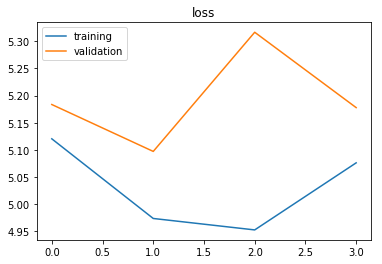

In [22]:
plt.plot(fit.history['loss'],    label='training')
plt.plot(fit.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()
#weightwatcher.plot()

In [23]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(test_x)
#test_predict = np.resize(test_predict, (100, 2))
test_result = np.concatenate((test_y, test_predict), axis=1)

In [71]:
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])
test_results_df[['unit_number', 'time']] = test_.reset_index(drop=False)[["unit_number", "time"]]

# test_results_df = pd.concat([test_x_orig, test_results_df], axis=1)
# test_results_df = test_results_df.merge(test_x_orig, on=['unit_number'], how='right')

In [72]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

In [73]:
def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

In [74]:
import scipy
def weibull_mean(alpha, beta):
    return alpha * scipy.special.gamma(1 + 1/beta)

In [75]:
def weibull_mode(alpha, beta):
    # assert len(alpha) == len(beta)
    assert np.all(beta > 0)
    try:
        return alpha * ((beta-1)/beta)**(1/beta) if beta > 1 else 0
    except ValueError:
        x = alpha * ((beta-1)/beta)**(1/beta)
        x[beta <= 1] = 0
        return x
    

In [76]:
def weibull_conf(alpha, beta, c):
    return alpha * np.power(np.log(1./(1-c)), 1./beta)

In [77]:
test_results_df['T'].describe()

count    12898.000000
mean       141.587533
std         58.939332
min          7.000000
25%        102.000000
50%        141.000000
75%        179.000000
max        340.000000
Name: T, dtype: float64

alpha 141.1601112673016 beta 3.1685242858630294


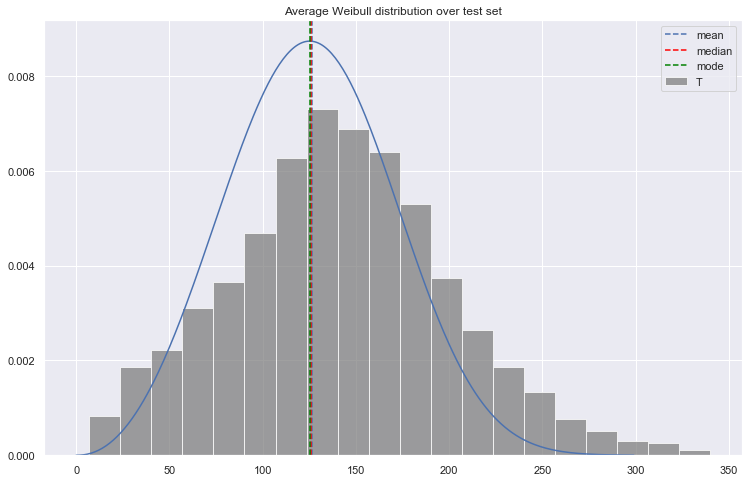

In [78]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, normed=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [52]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
t=np.arange(0,300)
alpha = train_results_df['alpha'].mean()
beta = train_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(train_results_df['T'], 20, normed=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over train set')
print('alpha', alpha, 'beta', beta)

NameError: name 'train_results_df' is not defined

In [ ]:
import seaborn as sns
palette=sns.color_palette("RdBu_r", 50)

In [ ]:
sns.palplot(palette)

In [ ]:
train_orig.describe()

In [ ]:
feature_columns = [x for x in test_x_orig.columns if x not in {'unit_number', 'time'}]

mins=train_orig[feature_columns].min()
maxs=train_orig[feature_columns].max()

for unit_no, grp in test_x_orig.groupby('unit_number'):
    df=grp.set_index('time')
    df = df[feature_columns]
    df=(df - mins)/ (maxs - mins)
    df.plot(figsize=(12.5,8))
    plt.title(unit_no)
    plt.show()

In [ ]:
import seaborn as sns
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,400)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)    
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()


In [ ]:
plot_weibull_predictions(results_df=test_results_df)

In [79]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

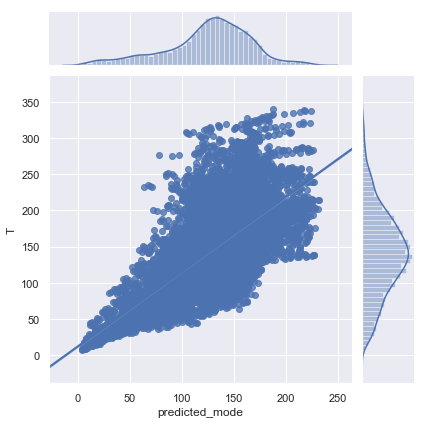

In [80]:
import seaborn as sns
sns.jointplot(data=test_results_df, y='T', x='predicted_mode',kind="reg")

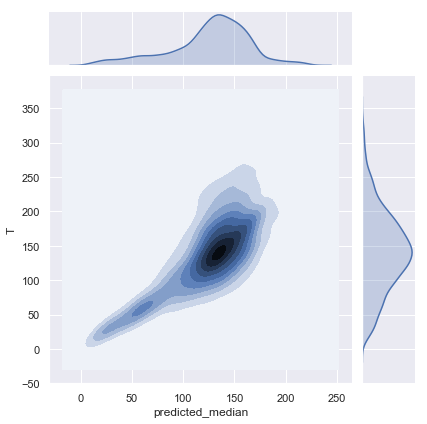

In [81]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median',kind="kde" )

In [82]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']

In [83]:
test_results_df['error'].describe()

count    12898.000000
mean        15.787408
std         40.900554
min        -88.078084
25%         -9.952477
50%          7.914802
75%         35.644700
max        201.165689
Name: error, dtype: float64

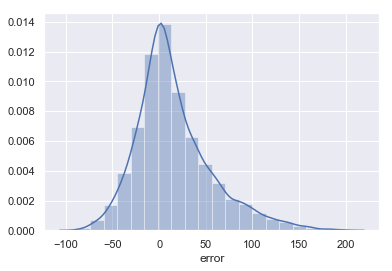

In [84]:
sns.distplot(test_results_df['error'], bins=20)

# Training evaluation

In [ ]:
train_x.shape

In [ ]:
train_y.shape

In [ ]:
train_predict=model.predict(train_x)
# train_predict = np.resize(train_predict, (20631, 2))
# train_result = np.concatenate((train_y, train_predict), axis=1)

In [ ]:
train_predict.shape
train_result = np.concatenate((train_y, train_predict), axis=1)

In [ ]:
train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])

In [ ]:
train_results_df[['unit_number', 'time']] = train_.reset_index(drop=False)[['unit_number', 'time']]

In [ ]:
train_results_df['unit_number'].nunique()

In [ ]:
train_results_df.shape

In [ ]:
train_results_df.head(100)

In [ ]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp)


In [ ]:
train_results_df.beta.min()

In [ ]:
train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)

In [ ]:
# import seaborn as sns
jp = sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="reg")
jp.set_axis_labels("Predicted median TTF", "True TTF", fontsize=12)
jp.ax_joint.set_title("Predicted vs. true time to failure", y=1.2)

In [ ]:
h = sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="kde" )
h.set_axis_labels("Predicted median TTF", "True TTF", fontsize=12)
h.ax_joint.set_title("Kernel density estimate of Predicted vs. true TTF", y=1.2)

In [ ]:
train_results_df['error'] = train_results_df['T']-train_results_df['predicted_median']

In [ ]:
train_results_df['error'].describe()

In [ ]:
sns.distplot(train_results_df['error'], bins=25)
plt.xlabel("Prediction median error")
plt.ylabel("Fraction of total")
plt.title("Distribution of errors of predicted median TTF")

In [85]:
test_results_df["02_CI"] = test_results_df[["alpha", "beta"]].apply(lambda cols: weibull_conf(cols[0], cols[1], 0.2), axis=1)
test_results_df["08_CI"] = test_results_df[["alpha", "beta"]].apply(lambda cols: weibull_conf(cols[0], cols[1], 0.8), axis=1)
test_results_df["095_CI"] = test_results_df[["alpha", "beta"]].apply(lambda cols: weibull_conf(cols[0], cols[1], 0.95), axis=1)

In [86]:
sns.set()

D:\anaconda\envs\nlp\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


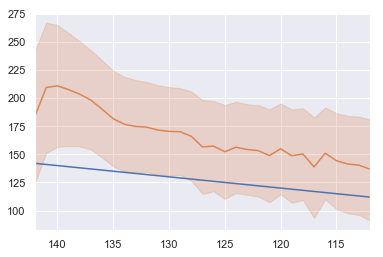

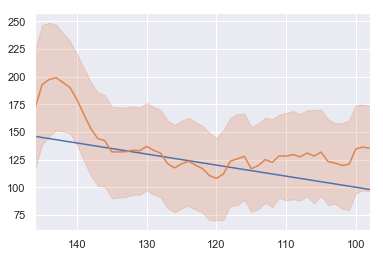

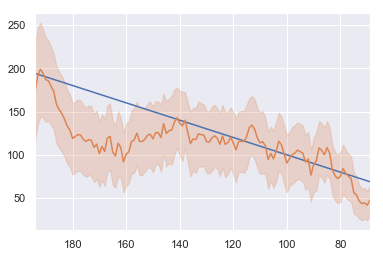

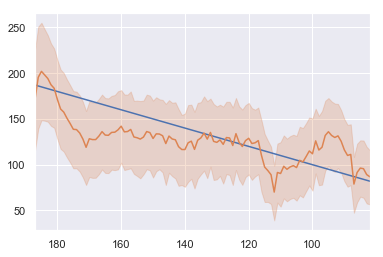

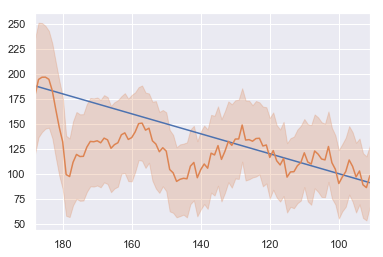

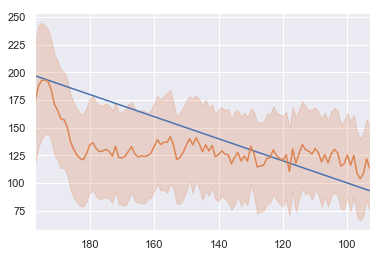

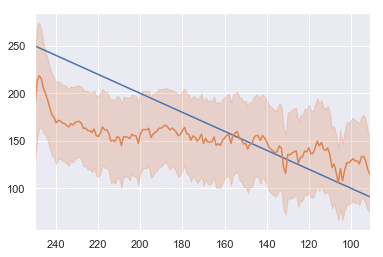

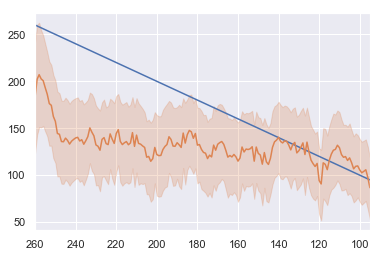

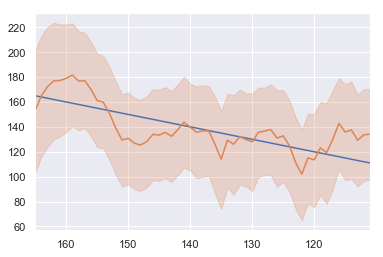

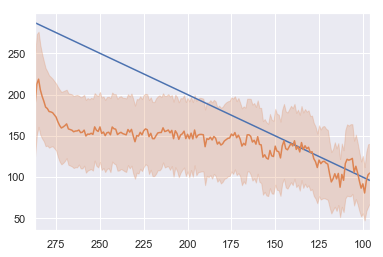

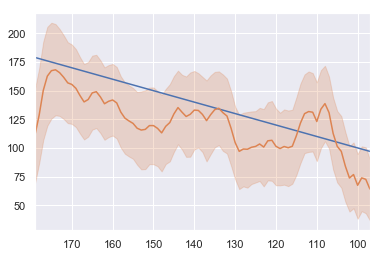

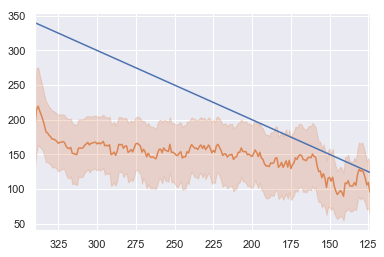

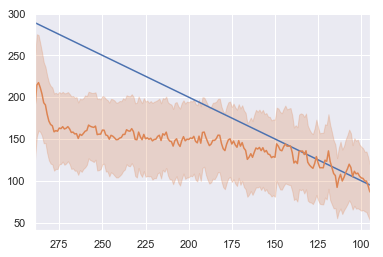

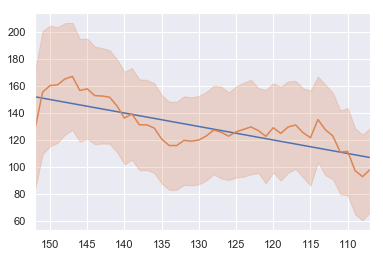

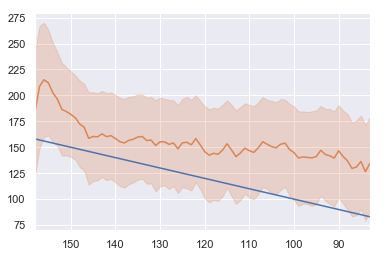

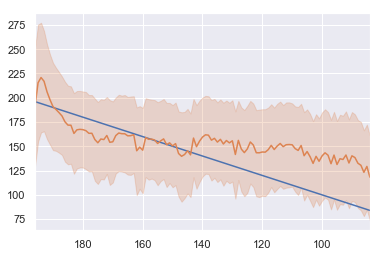

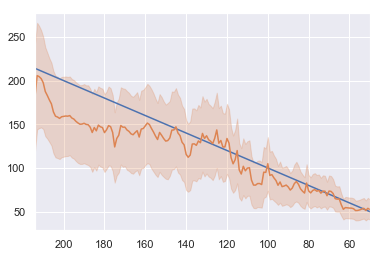

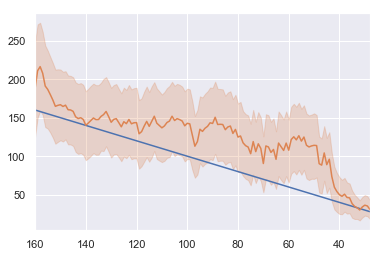

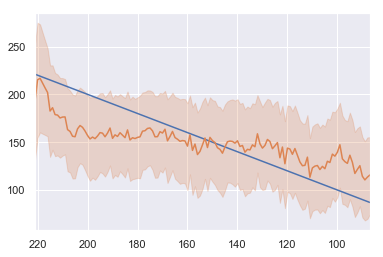

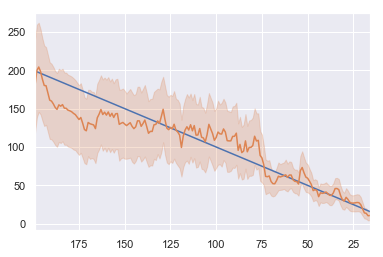

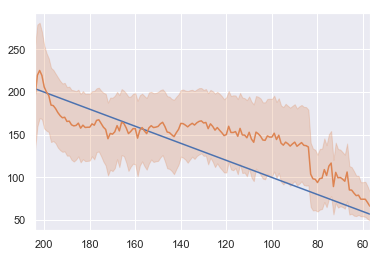

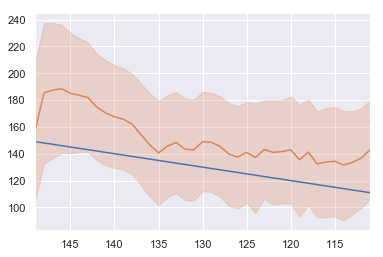

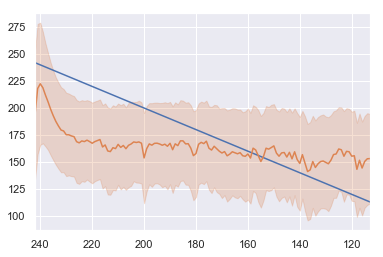

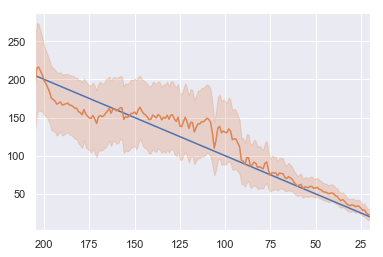

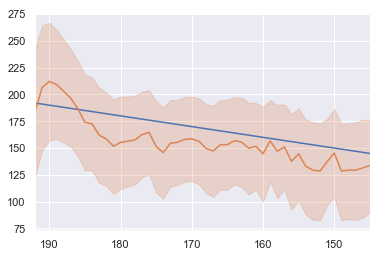

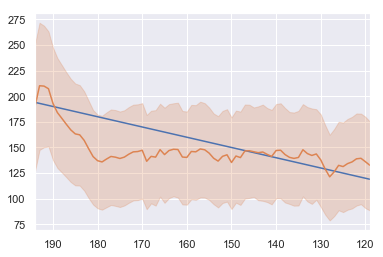

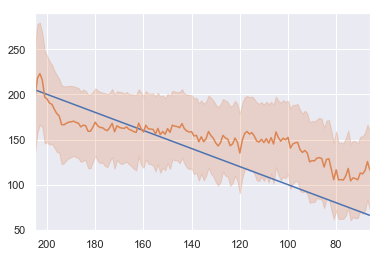

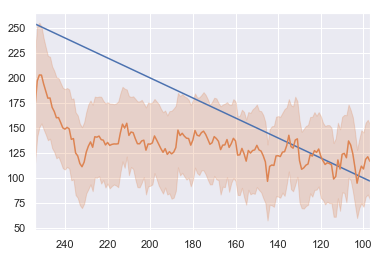

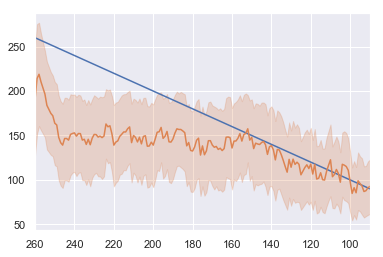

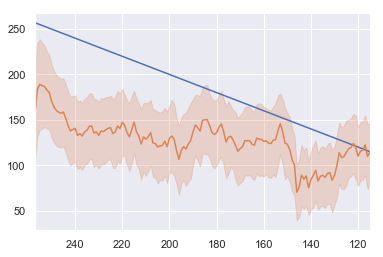

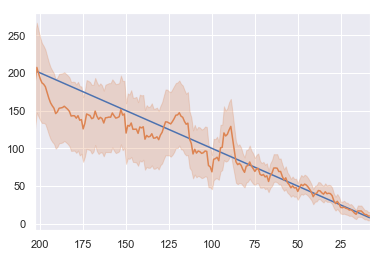

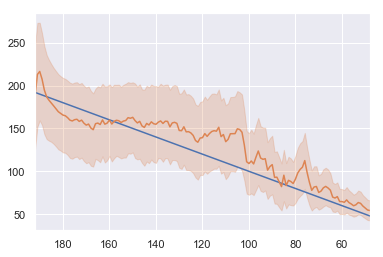

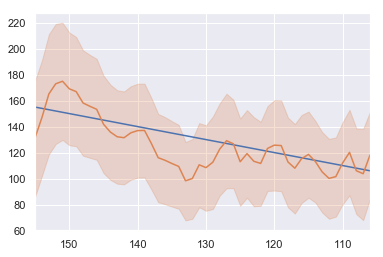

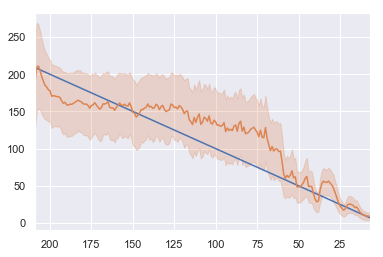

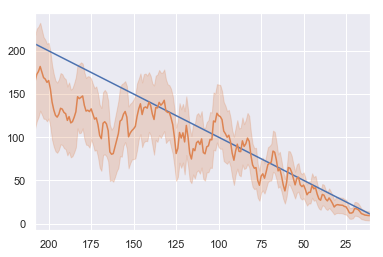

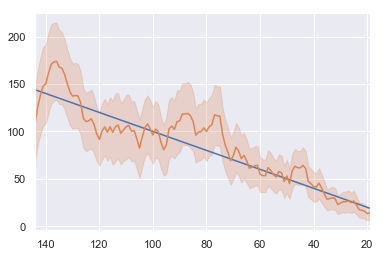

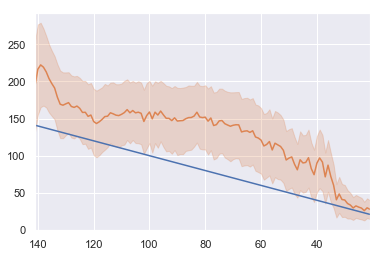

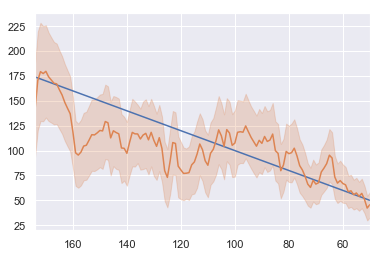

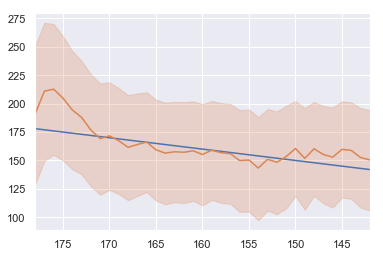

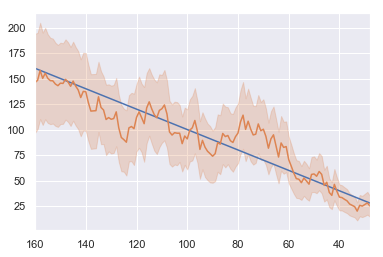

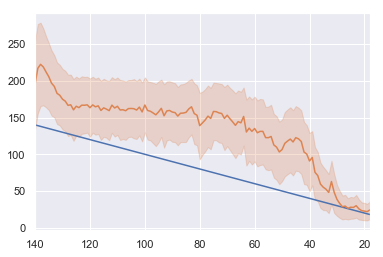

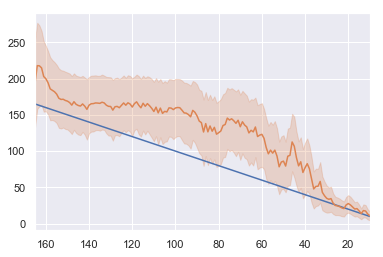

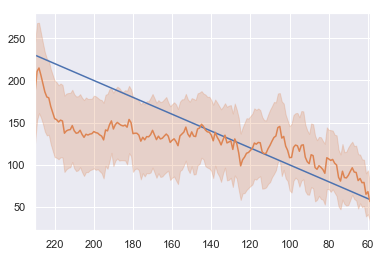

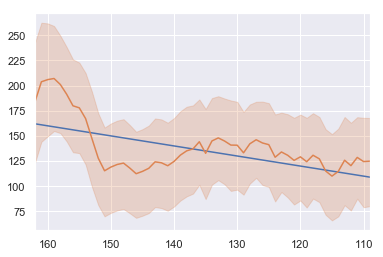

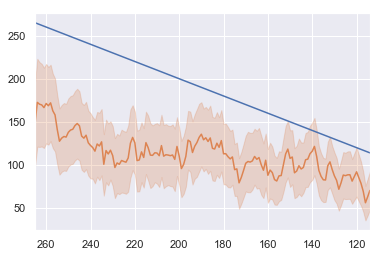

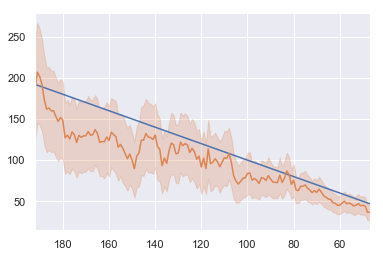

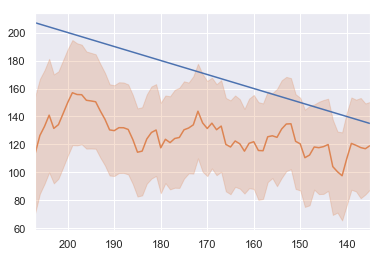

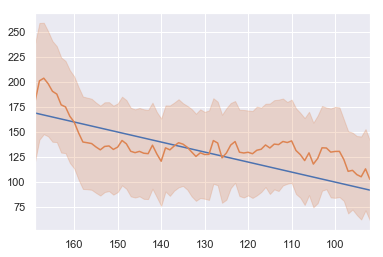

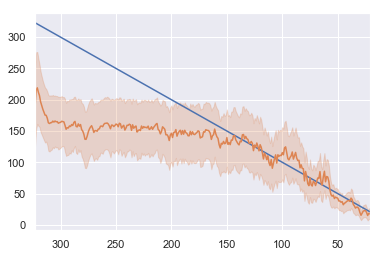

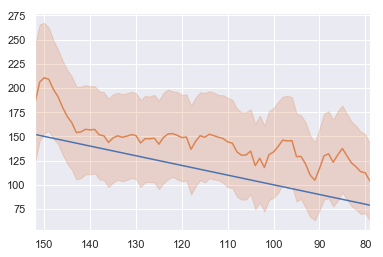

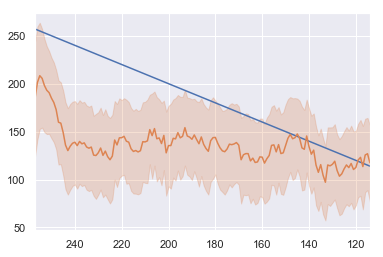

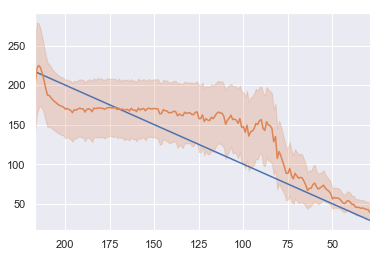

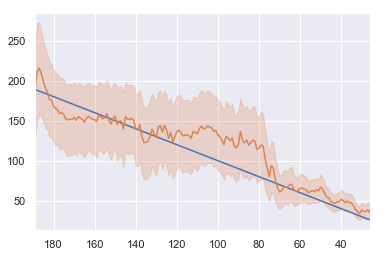

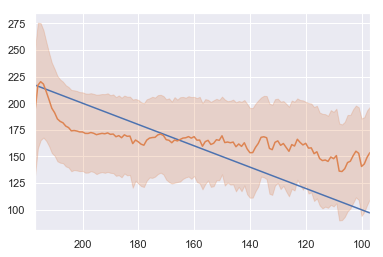

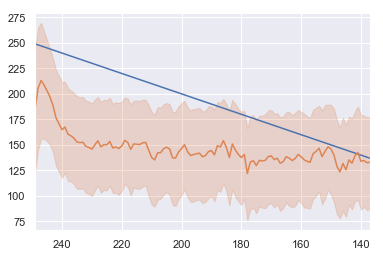

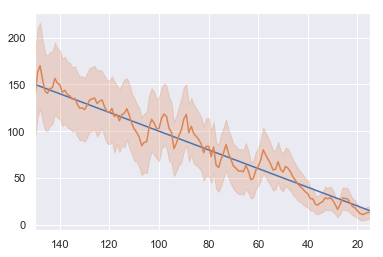

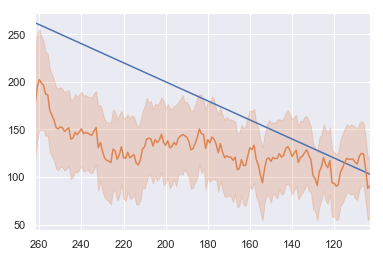

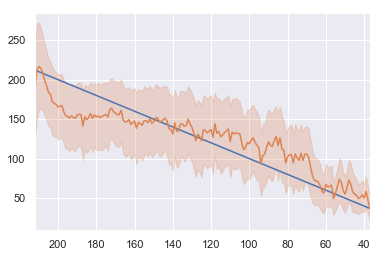

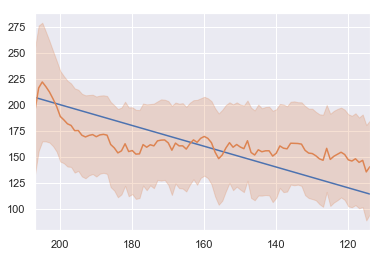

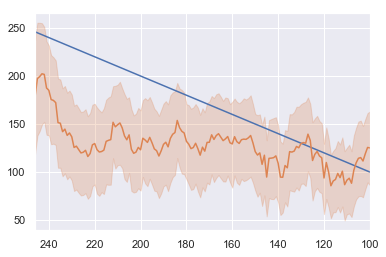

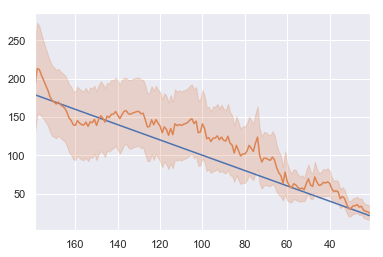

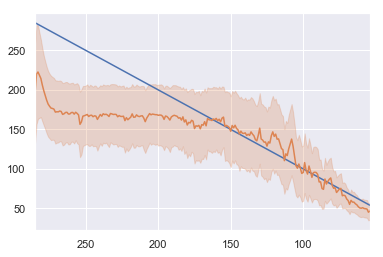

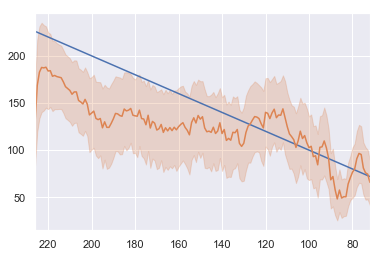

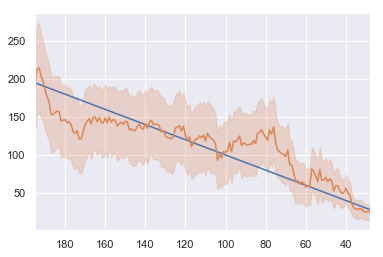

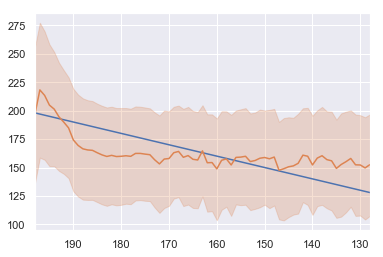

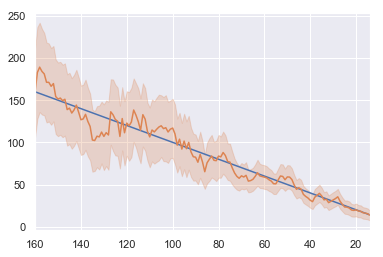

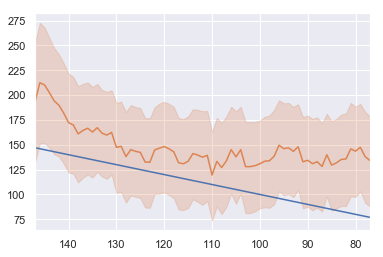

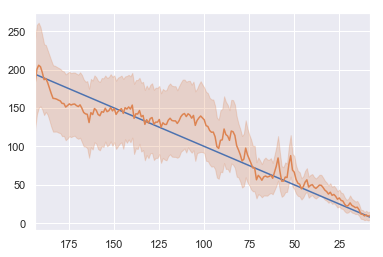

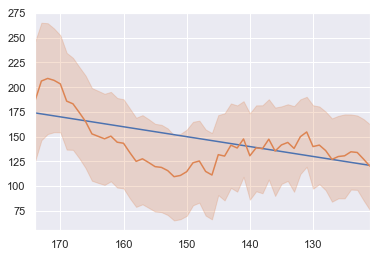

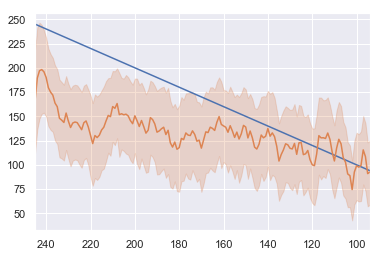

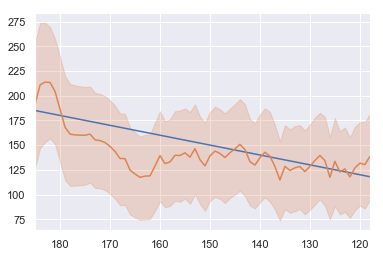

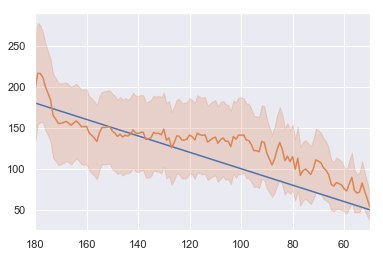

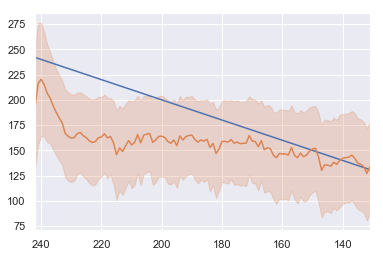

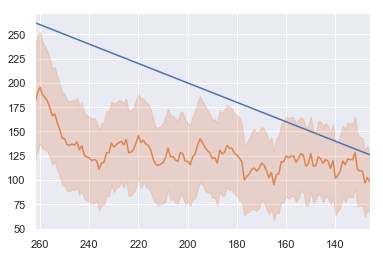

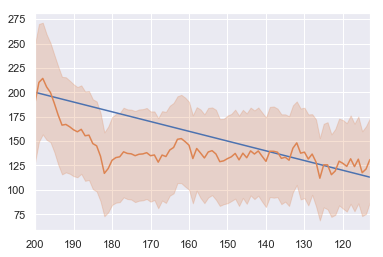

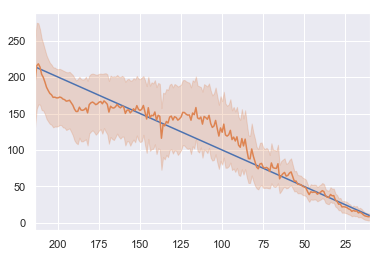

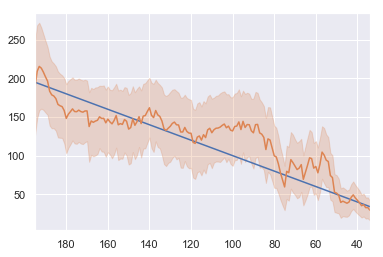

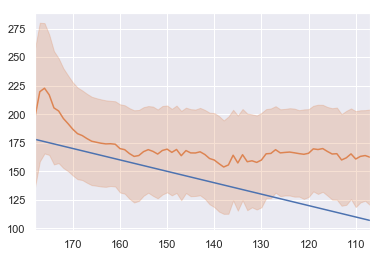

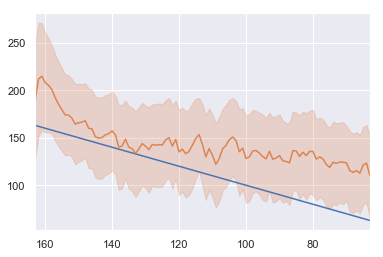

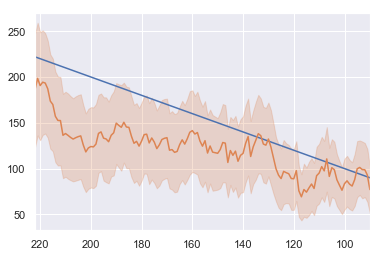

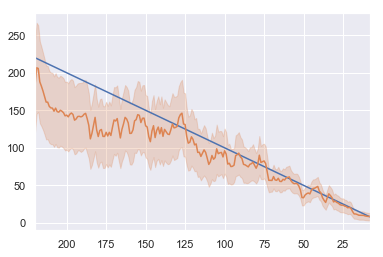

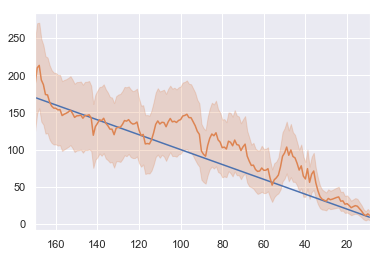

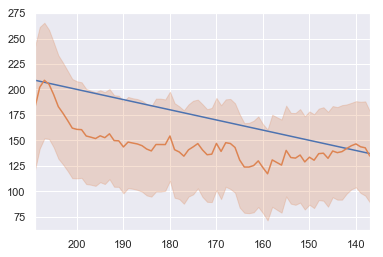

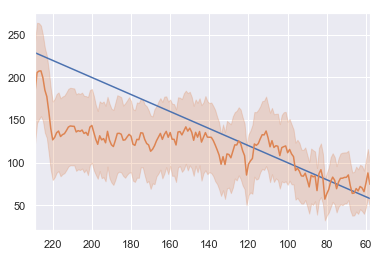

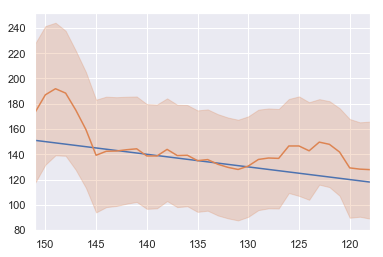

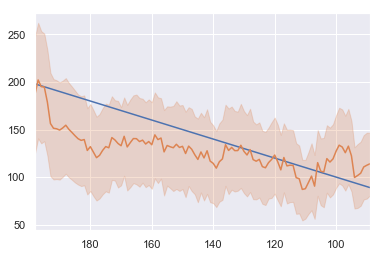

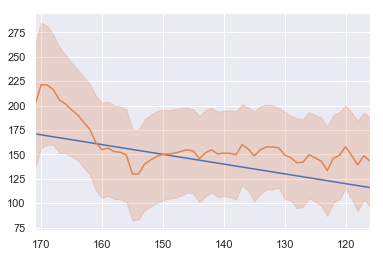

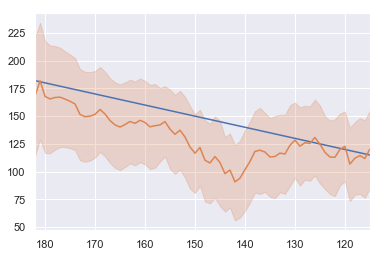

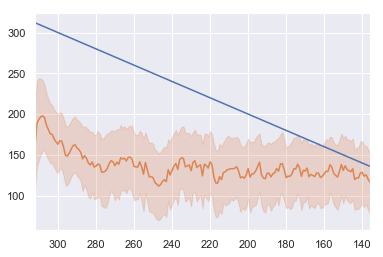

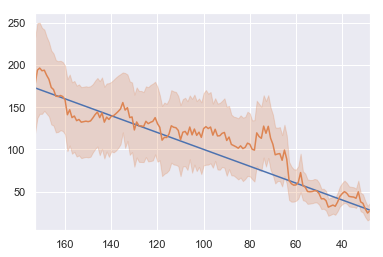

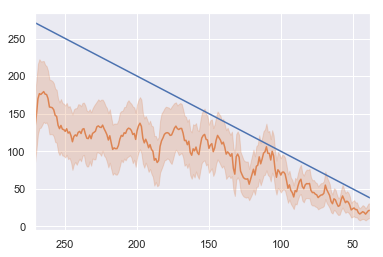

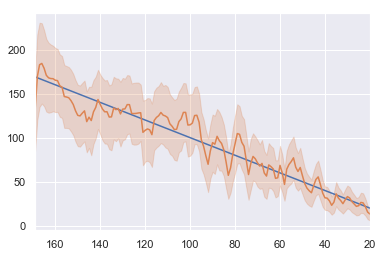

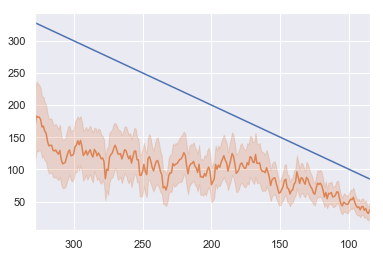

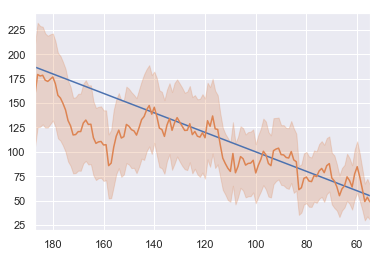

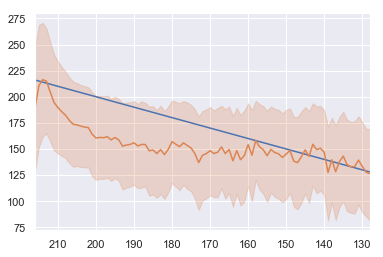

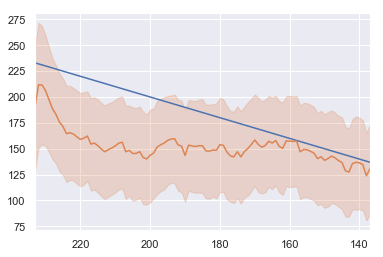

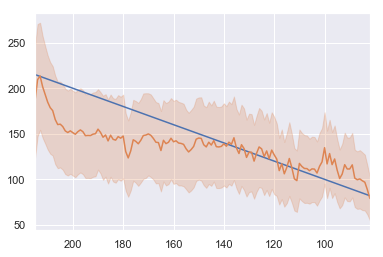

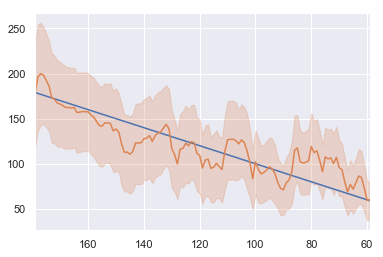

In [87]:
for n in range(test_results_df.unit_number.max()):
    fig, ax = plt.subplots()
    sub_df = test_results_df[test_results_df.unit_number == n]
    ax.set_xlim(sub_df["T"].max(), sub_df["T"].min())
    ax.plot(sub_df["T"], sub_df["T"])
    l = ax.plot(sub_df["T"], sub_df["predicted_mu"])
    ax.fill_between(sub_df["T"], sub_df["02_CI"], sub_df["08_CI"], alpha = 0.25, color = l[-1].get_color())

In [ ]:
dummy_df = test_results_df[["unit_number", "time", "predicted_median", "08_CI", "095_CI"]]

In [ ]:
dummy_cycles = pd.Series(np.random.randint(50, 34000, 100))
map_val = dummy_df["unit_number"].map(dummy_cycles)
dummy_df.loc[:, "flight_cycles"] = map_val - dummy_df.time

In [ ]:
dummy_df["flight"] = np.random.randint(10, 9999, dummy_df.shape[0])

In [ ]:
dummy_df.loc[:, "subtype"] = np.random.choice(["A319", "A320", "A321"], dummy_df.shape[0], True, np.array((0.3,0.63, 0.07)))

In [ ]:
dummy_df = dummy_df.loc[dummy_df.groupby("unit_number")["time"].tail(10).index]

In [ ]:
dummy_df.insert(dummy_df.shape[1], "IATA_origin", "")
dummy_df.insert(dummy_df.shape[1], "IATA_destination", "")

In [ ]:
dummy_df.head(11)

In [ ]:
dummy_out = dummy_df[["unit_number", "flight", "flight_cycles",
                      "predicted_median", "08_CI", "095_CI", 
                      "subtype"]].rename(columns={"unit_number": "msn"})

In [ ]:
dummy_out.head(5)

In [ ]:
dummy_out.to_excel("sample.xlsx", index=False)

In [24]:
train_x.shape

(20431, 25, 17)

In [32]:
model.predict(train_[new_features].values[np.newaxis, -55:-30])

array([[31.66344 ,  2.122409]], dtype=float32)